# bb1569 Assignment 1 for PUI2017 HW6

NEED TO REVIEW AND MAKE PLOTS

GENERAL QUESTION: HOW DOES ENERGY CONSUMPTION RELATED TO NUMBER OF UNITS.

In [72]:
from __future__ import print_function, division
import geopandas as gp
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab as pl
import os
import json
np.random.seed(910)

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopanda works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

### So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

 Either obtain the data through the API or download the csv file, and move it to $PUIDATA

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [2]:
#os.system("curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv")
#os.system("mv rows.csv "+os.getenv("PUIDATA"))
os.system("curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v2.zip")
os.system("mv mn_mappluto_16v2.zip "+os.getenv("PUIDATA"))
os.system("unzip -d $PUIDATA $PUIDATA/mn_mappluto_16v2.zip")

256

In [3]:
nrg = gp.GeoDataFrame.from_csv(os.getenv("PUIDATA") + "/rows.csv")
# exploring the data a bit
nrg.head()

,BBL,Co-reported BBL Status,BBLs Co-reported,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,DOF Benchmarking Submission Status,Site EUI(kBtu/ft2),...,DOF Property Floor Area (Buildngs and Parking)(ft2),Primary Property Type - Self Selected,DOF Number of Buildings,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,NTA
Record Number,,,,,,,,,,,,,,,,,,,,,
12086,1.000410e+09,NaN,1000410001,1001007,NaN,NaN,Manhattan,NaN,BBL not valid,NaN,...,NaN,Office,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14354,4.021460e+09,NaN,NaN,NaN,63-10,108 STREET,Queens,11375.0,No Submission Matched to BBL,NaN,...,82730.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12150,2.027620e+09,NaN,2027620097,2006460,NaN,NaN,Bronx,NaN,BBL not valid,NaN,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12590,1.006700e+09,NaN,NaN,NaN,201,11 AVENUE,Manhattan,10001.0,No Submission Matched to BBL,NaN,...,440360.0,NaN,1.0,40.749652,-74.006471,4.0,3.0,99.0,1012266.0,Hudson Yards-Chelsea-Flatiron-Union Square ...
15591,2.048300e+09,NaN,2048300034,2063117,NaN,NaN,Bronx,NaN,Not on Covered Buildings List,NaN,...,NaN,Multifamily Housing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
nrg.columns

Index(['BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [5]:
nrg=nrg[['BBL','Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode','Site EUI(kBtu/ft2)',
       'Source EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)','DOF Number of Buildings']]
nrg.head()
## Keeping some columns for graphic purposes

,BBL,Reported NYC Building Identificaiton Numbers (BINs),Street Number,Street Name,Borough,Postcode,Site EUI(kBtu/ft2),Source EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
Record Number,,,,,,,,,,,
12086,1.000410e+09,1001007,NaN,NaN,Manhattan,NaN,NaN,NaN,918919,NaN,NaN
14354,4.021460e+09,NaN,63-10,108 STREET,Queens,11375.0,NaN,NaN,NaN,82730.0,1.0
12150,2.027620e+09,2006460,NaN,NaN,Bronx,NaN,NaN,NaN,64200,NaN,NaN
12590,1.006700e+09,NaN,201,11 AVENUE,Manhattan,10001.0,NaN,NaN,NaN,440360.0,1.0
15591,2.048300e+09,2063117,NaN,NaN,Bronx,NaN,NaN,NaN,50000,NaN,NaN


In [6]:
bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")
bsize.head()

,Borough,Block,Lot,CD,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,...,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area,geometry
0,MN,1,201,101,1,1000,02,1,10004,E007,...,10101,,0.000000e+00,,1,16V2,0,6306.265838,1.148541e+06,"POLYGON ((973154.7117999941 194614.3315999955,..."
1,MN,9,14,101,9,1013,02,1,10004,L015,...,10101,,1.000090e+09,12/26/1985,1,16V2,0,686.230174,2.373306e+04,"POLYGON ((980492.3622000068 195423.9451999962,..."
2,MN,15,7501,101,13,2005,02,1,10004,E010,...,10101,,1.000150e+09,12/29/1998,1,16V2,7,1098.925676,6.753824e+04,"POLYGON ((979999.0820000023 196493.2800000012,..."
3,MN,13,5,101,13,2008,02,1,10004,E010,...,10101,,0.000000e+00,,1,16V2,0,709.632239,3.068607e+04,"POLYGON ((980424.4003999978 196274.334800005, ..."
4,MN,1,10,101,5,1018,02,1,10004,E007,...,10101,,0.000000e+00,,1,16V2,0,12277.830569,7.550344e+06,"POLYGON ((979561.8711999953 191884.2495999932,..."


In [7]:
bsize.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010', 'SchoolDist',
       'Council', 'ZipCode', 'FireComp', 'PolicePrct', 'HealthArea',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'Address', 'ZoneDist1',
       'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'Overlay1', 'Overlay2',
       'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight', 'SplitZone', 'BldgClass',
       'LandUse', 'Easements', 'OwnerType', 'OwnerName', 'LotArea', 'BldgArea',
       'ComArea', 'ResArea', 'OfficeArea', 'RetailArea', 'GarageArea',
       'StrgeArea', 'FactryArea', 'OtherArea', 'AreaSource', 'NumBldgs',
       'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'LotDepth',
       'BldgFront', 'BldgDepth', 'Ext', 'ProxCode', 'IrrLotCode', 'LotType',
       'BsmtCode', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot',
       'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist', 'Landmark',
       'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode', 'BBL',
       'CondoNo', 'Tract2010', 'XCoord', 'YCoord'

In [8]:
bsize=bsize[["UnitsRes", 'UnitsTotal',"BBL"]]
bsize.head()

,UnitsRes,UnitsTotal,BBL
0,0,0,1.000010e+09
1,0,0,1.000090e+09
2,500,602,1.000158e+09
3,0,50,1.000130e+09
4,0,0,1.000010e+09


As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

## Exploratory analysis

/Users/biancabrusco/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


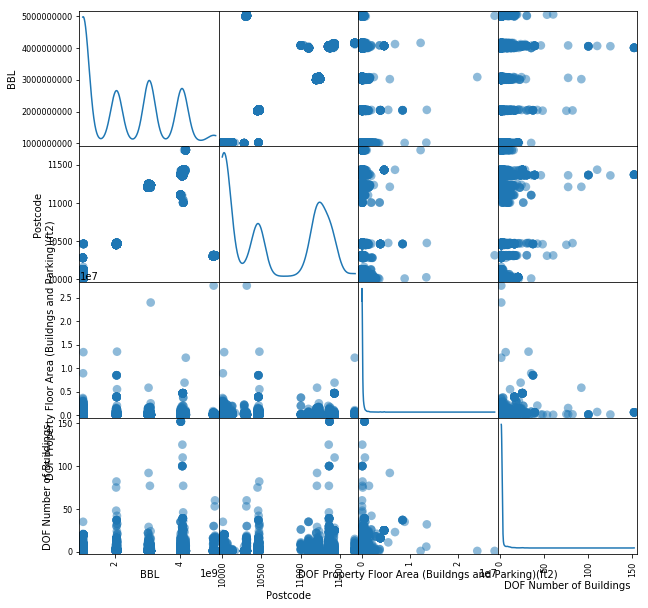

In [9]:
#try make a scatter plot of nrg. Few columns will plot - only those that have numerical values. 
#Pandas will ignore the other ones
from pandas.tools.plotting import scatter_matrix
sfig = scatter_matrix (nrg, s=300, figsize=(10, 10), diagonal='kde')

**Figure 1:** Scatter matrix of all numerical values in the files. 
Note: this are not all the variables, I have already cut my datasets to remove a bunch of columns. These are some of the variables, but still the ones of interest are not plotted. The plot is not very informative in terms of the correlation 

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries.  
The columns I am interested in are in fact **u'Site EUI(kBtu/ft2)'** which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. **u'Reported Property Floor Area (Building(s)) (ft²)'**. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, buy setting it to "coerce". Please look at the function documentation to understand the syntax.

In [10]:
nrg["Site EUI(kBtu/ft2)"]=pd.to_numeric(nrg['Site EUI(kBtu/ft2)'],errors="coerce")
nrg["Reported Property Floor Area (Building(s)) (ft²)"]=pd.to_numeric(nrg["Reported Property Floor Area (Building(s)) (ft²)"],errors="coerce")
##check that your conversion worked: e.g.

#print(nrg["BBL"].astype(float)) #no conversion necessary
#print (nrg['Site EUI(kBtu/ft2)'].astype(float))
#print(nrg["Reported Property Floor Area (Building(s)) (ft²)"].astype(float))

#bsize.BBL.astype(float) #no conversion necessary

In [11]:
#drop everything you do not need to lighten the memory load on your machine! this is important!! 
#this file has a lot of columnsm most of them you will not need
nrg.columns

Index(['BBL', 'Reported NYC Building Identificaiton Numbers (BINs)',
       'Street Number', 'Street Name', 'Borough', 'Postcode',
       'Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'DOF Number of Buildings'],
      dtype='object')

In [12]:
nrg=nrg[['BBL','Site EUI(kBtu/ft2)','Reported Property Floor Area (Building(s)) (ft²)']]
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
Record Number,,,
12086,1.000410e+09,NaN,918919.0
14354,4.021460e+09,NaN,NaN
12150,2.027620e+09,NaN,64200.0
12590,1.006700e+09,NaN,NaN
15591,2.048300e+09,NaN,50000.0


In [13]:
#How many missing values?
indx = np.isnan(nrg['Site EUI(kBtu/ft2)']).sum()
print ("invalid entries changed to NaN for EUI %d"%sum(indx))

indx2 = np.isnan(nrg['Reported Property Floor Area (Building(s)) (ft²)']).sum()
print ("invalid entries changed to NaN for Floor Area %d"%sum(indx2))

invalid entries changed to NaN for EUI 4623
invalid entries changed to NaN for Floor Area 3125


** MERGE THE DATASETS**
look at the syntax for pandas.merge - this will be incredibly useful to you in all future data problem where you use Pandas and data aggregation is really at the heart of urban science!

NOTE: in 2017 file we have BBL in both so below is easier...

TO DO IT WE NEED A COMMON COLUMN: the building id, BBL is in both files. However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. 
You can rename the column, create a whole new column 'BBL' in the energy dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!). YOu can also say pd.merge(..., right_on=BBL, left_on="NYC Borough, Block, and Lot (BBL)'). Always make sure though that the data type is the same! both integers, both strings, or whatever but the same, or you will not be able to merge. 

In [14]:
(bsize.BBL.values[0]), (nrg.BBL.values[0])

(1000010201.0, 1000410001.0)

In [15]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL').dropna()
bblnrgdata.shape
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal
2,1.013110e+09,125.4,330000.0,0,56
10,1.010140e+09,154.9,841709.0,0,2
15,1.007660e+09,122.3,59468.0,0,8
16,1.008150e+09,117.0,364000.0,0,24
18,1.005050e+09,82.1,235370.0,0,24


/Users/biancabrusco/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


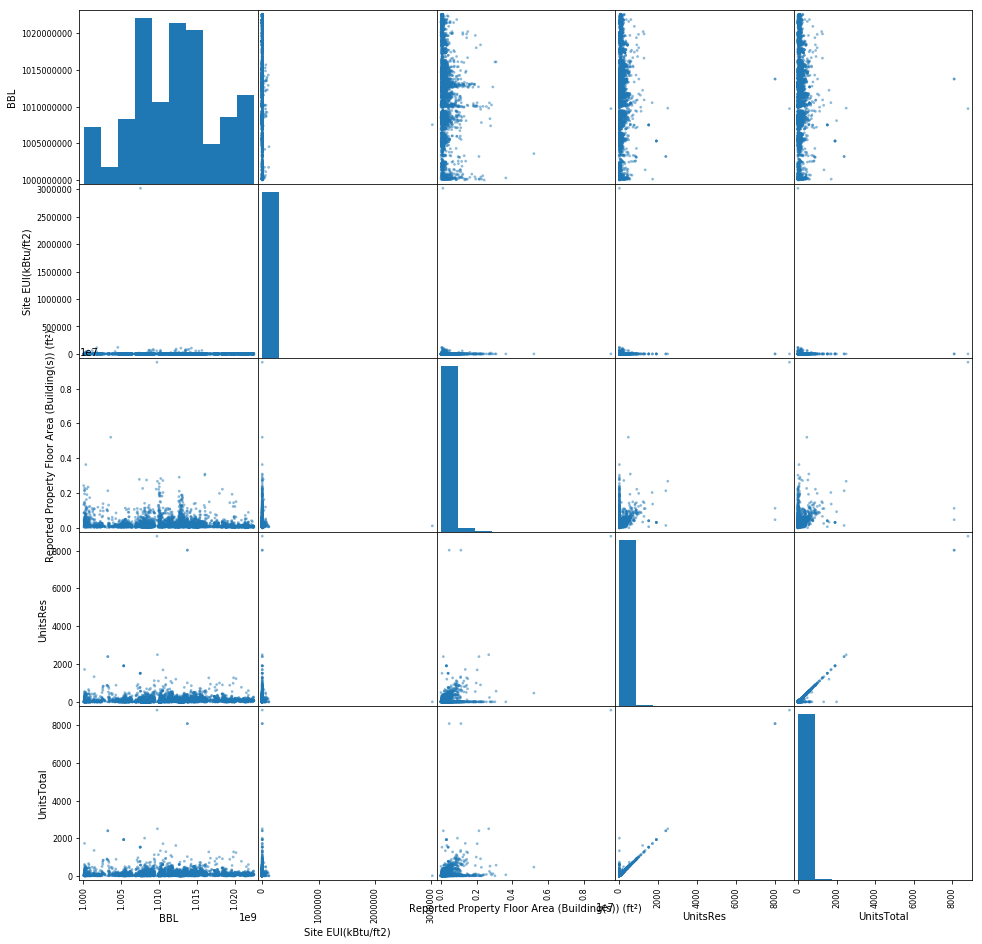

In [16]:
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16));

**Figure 2:** scatter matix of final dataset. All the variables of interest plot. No immediate correlation can be observed between variables of interest. 

When we produce a scatter matrix for the merged dataset -- the one we are actually going to use, we see correlation among variables like Reported Floor Area and Units Total, or Units Res (which intuitively makes sense... as building gets bigger it's more likely that it has more Units). The plot we are interested in is the one of "Units Total" vs "Site EUI kBtu/ft^2" , in which we see that most points are clustered at close to the zero axix on the x ... suggesting that there is some very large outliers in energy consumptions and also that their relationship might be better observed in log-log scale. 

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building.  **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [17]:
#Calculate total energy consumption, by including the area of the building
bblnrgdata["TotEnergy"] = bblnrgdata["Site EUI(kBtu/ft2)"]*bblnrgdata["Reported Property Floor Area (Building(s)) (ft²)"]
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,TotEnergy
2,1.013110e+09,125.4,330000.0,0,56,41382000.0
10,1.010140e+09,154.9,841709.0,0,2,130380724.1
15,1.007660e+09,122.3,59468.0,0,8,7272936.4
16,1.008150e+09,117.0,364000.0,0,24,42588000.0
18,1.005050e+09,82.1,235370.0,0,24,19323877.0


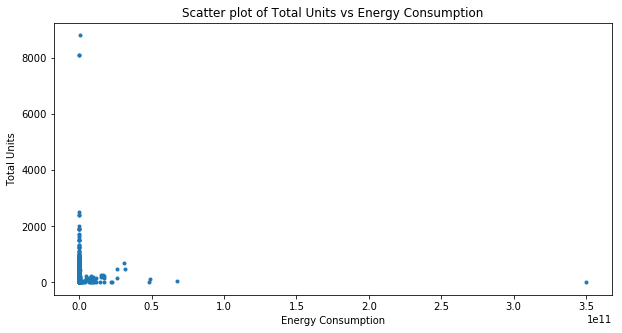

In [18]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)

pl.scatter(bblnrgdata["TotEnergy"],bblnrgdata["UnitsTotal"],marker=".");
pl.title("Scatter plot of Total Units vs Energy Consumption")
pl.ylabel("Total Units")
pl.xlabel("Energy Consumption")

**Figure3** A Scatter Plot of Total Units vs Energy Consumption per square foot

(0, 51000000000.0)

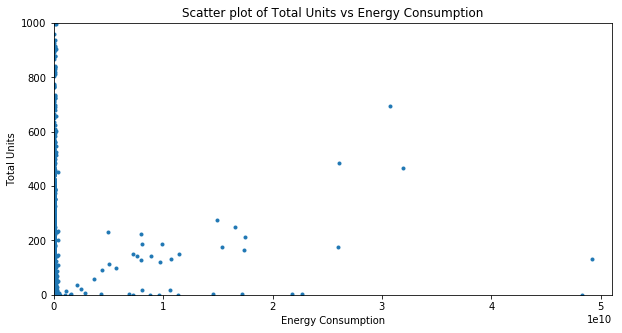

In [19]:
fig = pl.figure(figsize=(10,5))
ax = fig.add_subplot(111)

pl.scatter(bblnrgdata["TotEnergy"],bblnrgdata["UnitsTotal"],marker=".")
pl.title("Scatter plot of Total Units vs Energy Consumption")
pl.ylabel("Total Units")
pl.xlabel("Energy Consumption")
ylim(0,1000)
xlim(0,0.51e11)

** IMPORTANT NOTE ABOUT LOGS AND LOG PLOTS **
in class we talked about logs when we talked about likelihood: often we prefer working with the log(likelihood) instead of the likelihood, and since all problems involving likelihood are about maximization (find the maximum likelihood to find the best fit parameters) and the log is a MONOTONIC function (log(x) grows when x grows, and gets smaller when x gets smaller) the maximum of the likelihood of a model with be in the same place as the maximum of the log(likelihood). 

Another great thing about logarithm: **when the points in a plot all look scrunched against the axis **


**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

This will compress the high  x and high  y values, and compress the small x and small y values. 



NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [20]:
#you may need to change the name of this column under some versions of pandas
bblnrgdata['Reported Property Floor Area (Building(s))'] = \
            pd.to_numeric(bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'], 
                          errors='coerce').astype(float)

In [21]:
bblnrgdataCut = bblnrgdata[(bblnrgdata.TotEnergy > 1000) & (bblnrgdata.UnitsTotal>=10) & 
                           (bblnrgdata.UnitsTotal<1000)]

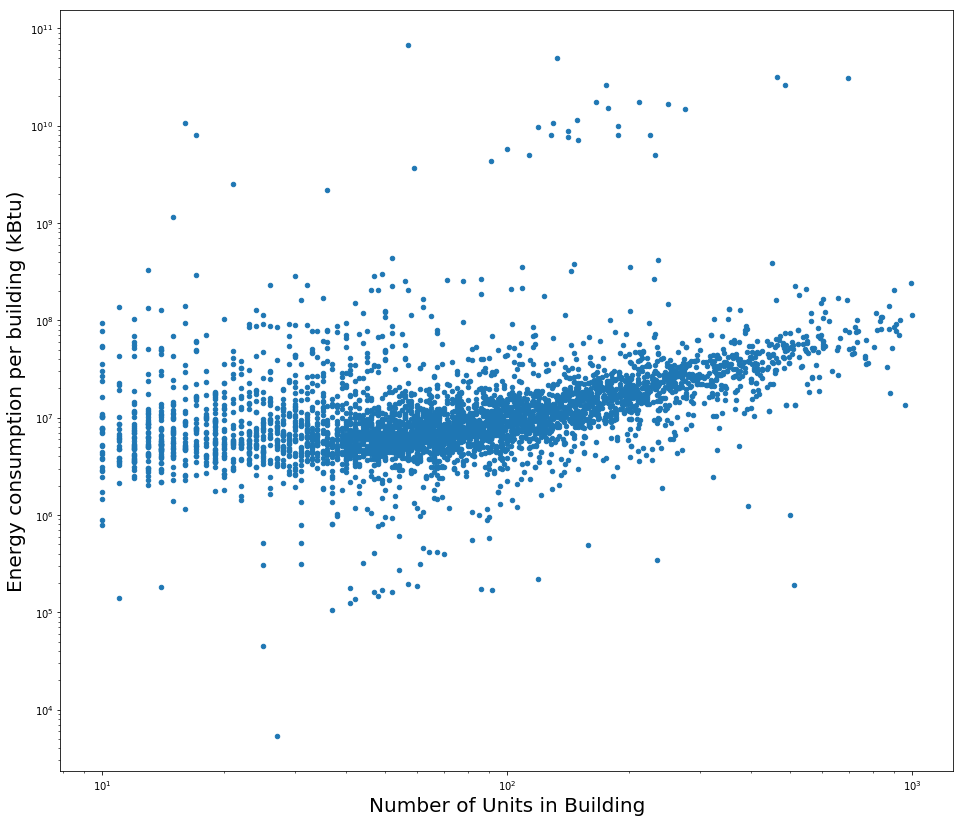

In [22]:
ax = bblnrgdataCut.plot(kind='scatter', y='TotEnergy', x='UnitsTotal', 
                  marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

**Figure5** Scatter plot of Units in Building vs Energy Consumed per Building on a log-log scale. Here we can observe a linear relation that we will investigate through linear models. 

Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

**BUT REMEMBER:** we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


## choose  which is your DEPENDENT and which is your INDEPENDENT variable. 
which is the "logical" IV: what are we assuming depends on what? energy on size of building or building on size of energy... discuss this but also test both fits, energy vs size and size vs energy. how can you compare these models? 



1. **Fit a line** to Units vs Energy. The independent variable in this problem should be number of units, but try fit both Unity to energy and energy to unit.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**.  Can you compare these models with the likelihood ratio test? (hint: are they nested??) I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is 
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
    $data(x_i)$ 
    is your observation, 
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors??)
    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2 + bx + c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



In [23]:
#MODEL OF ENERGY VS UNITS AND MDOEL OF UNITS VS ENERGY
#COMPARE THEM WITH CHI SQ
bblnrgdataCut.head()
bblnrgdataCut.describe()


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,TotEnergy,Reported Property Floor Area (Building(s))
count,4.266000e+03,4266.000000,4.266000e+03,4266.000000,4266.000000,4.266000e+03,4.266000e+03
mean,1.012354e+09,454.522035,1.958507e+05,103.635724,116.765588,1.228313e+08,1.958507e+05
std,5.474422e+06,4759.035650,2.646955e+05,126.649755,126.640083,1.728780e+09,2.646955e+05
min,1.000048e+09,0.100000,1.000000e+04,0.000000,10.000000,5.344000e+03,1.000000e+04
25%,1.008410e+09,66.000000,7.221750e+04,28.000000,43.000000,5.855188e+06,7.221750e+04
50%,1.012580e+09,82.000000,1.144430e+05,66.000000,75.000000,8.981647e+06,1.144430e+05
75%,1.015396e+09,100.500000,2.098830e+05,128.000000,139.000000,1.717188e+07,2.098830e+05
max,1.022500e+09,106472.700000,5.207812e+06,995.000000,997.000000,6.779388e+10,5.207812e+06


**Model of Total Energy per Building vs Total Units** 

In [56]:
X = sm.add_constant(np.log10(bblnrgdataCut.UnitsTotal))
linLog1 = sm.OLS(np.log10(bblnrgdataCut.TotEnergy),X, missing='drop').fit()
beta0_linLog1,beta1_linLog1=linLog1.params
linLog1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              TotEnergy   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     827.2
Date:                Fri, 20 Oct 2017   Prob (F-statistic):          2.05e-166
Time:                        15:40:26   Log-Likelihood:                -2563.5
No. Observations:                4266   AIC:                             5131.
Df Residuals:                    4264   BIC:                             5144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1110      0.033    187.012      0.000       6.047       6.175
UnitsTotal     0.4882      0.017     28.761      0.000       0.455       0.521
==============================================================================
Omnibus:                     2264.923   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44888.937
Skew:                           2.089   Prob(JB):                         0.00
Kurtosis:                      18.333   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

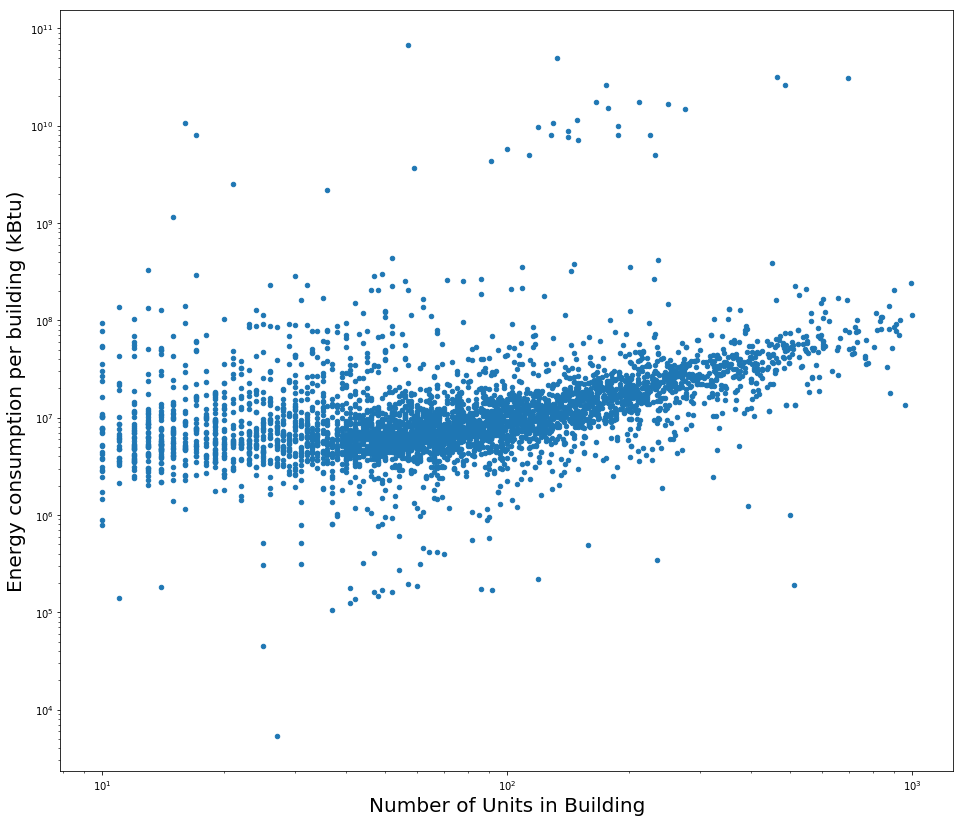

In [25]:
#I CANT GET PLOT TO WORK PROPERLY IN LOG LOG SCALE
ax = bblnrgdataCut.plot(kind='scatter', x='UnitsTotal', y='TotEnergy', 
                  marker='o',  figsize=(16, 14), loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

#ADD BEST FIT LINE HERE WITH MODEL . ABOVE....
#SEE PROFESSORS SLIDES ALSO DIFFERENT SCALE on X AND Y ..???

**Model of Total Units vs Total Energy per Building** 

In [57]:
X = sm.add_constant(np.log(bblnrgdataCut.TotEnergy))
linLog2 = sm.ols(np.log(bblnrgdataCut.UnitsTotal),X, missing='drop').fit()
beta0_linLog2,beta1_linLog2=linLog2.params
linLog2.summary()


#pl.plot(bblnrgdataCut.TotEnergy, beta0_linLog2+beta1_linLog2*bblnrgdataCut.TotEnergy)

AttributeError: module 'statsmodels.api' has no attribute 'ols'

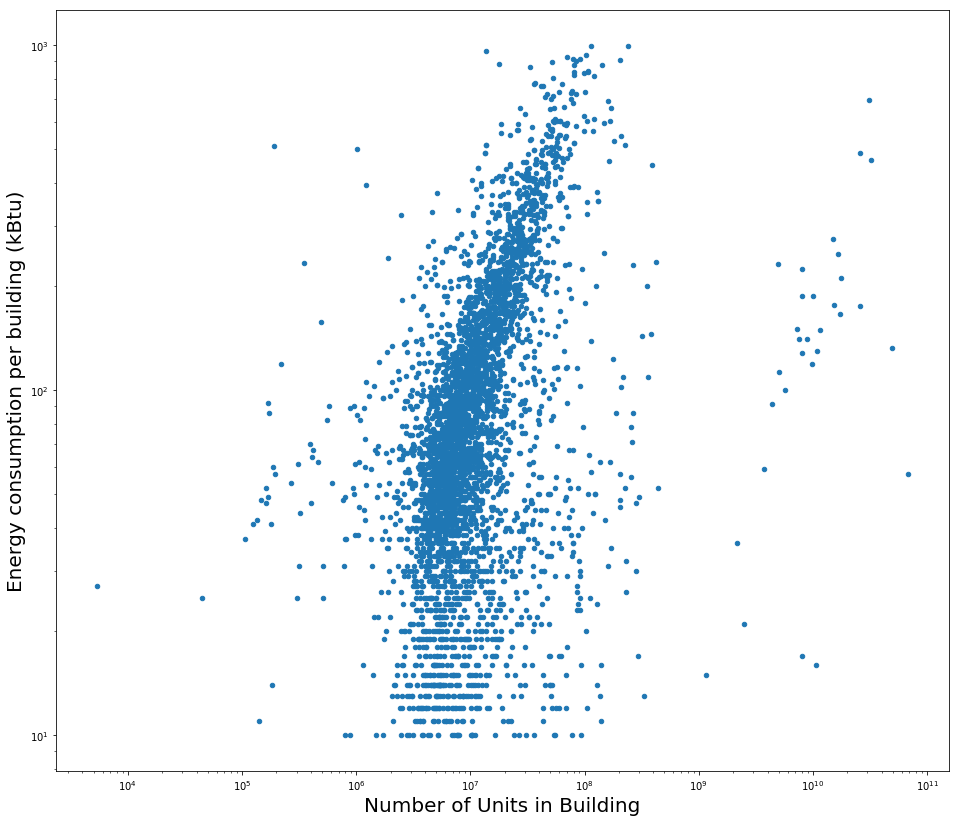

In [27]:
#AGAIN,PLOT SCATTER PLOT WITH LINE OF BEST FIT DOESNT REALLY WORK
ax = bblnrgdataCut.plot(kind='scatter', x='TotEnergy', y='UnitsTotal', 
                  marker='o',  figsize=(16, 14),loglog=True)
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)

#ADD CODE TO ADD LINE OF BEST FIT IN LOG SCALE... SEE PROFESSORS SLIDES ALSO DIFFERENT SCALE on X AND Y ..???

**CHI SQ COMPARISON OF TWO ABOVE MODELS**

We cannot use log-likelihood ratio test since models are not nested

In [58]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [59]:
#CACLULATE ERROR FOR ENERGY AND FOR UNITS.

#For energy,the error is the sqrt(x^2+y^2) where x and y are the FloorArea of the 
#Building and the Site EUI per ft2.

errorsenergy = np.sqrt((np.log(bblnrgdataCut['Reported Property Floor Area (Building(s))'])**2) +\
                np.sqrt((bblnrgdataCut['Site EUI(kBtu/ft2)']**2)))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(np.log(bblnrgdataCut.UnitsTotal))

In [47]:
chilinlog1=chi2(np.log(bblnrgdataCut.UnitsTotal),linLog1.predict(),errorsunits)
chilinlog1

8977.339431238192

In [48]:
chilinlog2=chi2(np.log(bblnrgdataCut.TotEnergy),linLog2.predict(),errorsenergy)
print(chilinlog2)

2677.509721980629


((NOTE: could calculate models p-values looking at a chisq table if you want to see how they compare/if the modeels are significant by this test.... not sure if she wants that?))

The Log Linear Model 1 (linLog1), which is using Units to predict Energy Consumption has a higher Chi2. 
This means that the model is a better fit than the one predicting Units with Energy as an independent variable -- Log Linear Model 2 (linLog2).   
We cannot do a Log-Likelihood Ratio Chi-Sq Test for this because they are not nested modes. 

**Fit Model with 2nd Deg Polynomial**

In [64]:
y = np.log(bblnrgdataCut.UnitsTotal)
x= np.log(bblnrgdataCut.TotEnergy)
x2=np.log(bblnrgdataCut.TotEnergy)**2


curveLog = smf.ols("y ~ x+x2", missing='drop', data=bblnrgdataCut).fit()
curveLog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     473.4
Date:                Fri, 20 Oct 2017   Prob (F-statistic):          2.16e-186
Time:                        15:41:59   Log-Likelihood:                -5254.8
No. Observations:                4266   AIC:                         1.052e+04
Df Residuals:                    4263   BIC:                         1.053e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1673      0.929    -10.946      0.000     -11.988      -8.346
x              1.4046      0.108     13.053      0.000       1.194       1.616
x2            -0.0313      0.003    -10.017      0.000      -0.037      -0.025
==============================================================================
Omnibus:                      114.002   Durbin-Watson:                   1.372
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.012
Skew:                          -0.381   Prob(JB):                     4.33e-28
Kurtosis:                       3.357   Cond. No.                     1.96e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
##MISSING PLOT OF FIT LINE GOING THROUGH PLOITS!!!!!!!! 

**CALCULATE LOG LIKELIHOOD**

We get the Log Likelihood from the summaries--

In [71]:
print ("LR : ", -2 * (-linLog1.llf - (-curveLog.llf)))
print ("LR from statsmodels:", curveLog.compare_lr_test(linLog1)) #largest model's attribute

LR :  5382.50657785
LR from statsmodels: (-5382.5065778454464, 1.0, 1.0)


Interpretation: with a p-value of 1, we fail to reject the null hypothesis that the smaller model holds. 
I.e, the model with the x2 term is not signficantly better than the one without. We choose the simpler, linear model.

In [70]:
###FINISHED WORKING HERE....

  
  
   
   
   
    
      
      
       
        
         
## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [ ]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

In [ ]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)